Investigating the FA-DELs of the DTU 10 MW.

Start by importing things and loading the stats file.

In [45]:
import warnings

from lacbox.io import ReadHAWC2
from lacbox.postprocess import rainflow_windap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

res_dir = 'C:/Users/rink/git/G-lac/lac-course-private/run-hawc2/res_turb/'  # stats dir and subfolder time seris

Define a function to load statistics data and add a wind speed columnn based on filenames.

In [2]:
def load_stats(stats_path, subfolder=None):
    """Load a stats file and add wind speed column"""
    # isolate the simulations for the turbl class
    stats_df = pd.read_hdf(stats_path, 'stats_df')
    if subfolder is not None:
        df = stats_df[stats_df.subfolder == subfolder]

    # make a column of wind speeds and save unique values
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        df['wsp'] = df.filename.apply(lambda s: float(s.split('_')[-2]))
    wsps = np.sort(df.wsp.unique())
    
    return df, wsps

Import the statistics data.

In [3]:
stats_path = res_dir + 'dtu_10mw_turb_stats.hdf5'
subfolder = 'tca'
df, wsps = load_stats(stats_path, subfolder=subfolder)

Let's define our channel indices.

In [4]:
chans = dict(wsp=15, omega=10, pitch=4, power=111, gentrq=81,  # wsp, rotor speed, pitch, power, generator torque
             tbfa=19, tbss=20, ttpt=22, ttrl=23,  # tower-base fore-aft and side-side, tower-top pitch and roll
             fbrm=37, ebrm=38)  # flapwise and edgewise blade-root moment

Define a function to plot a specific key and statistic.

In [5]:
def plot_val(df, key, stat, ax=None, title=None, figsize=(10, 3), **kwargs):
    if title is None:
        title = key
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    # isolate data
    x_val = df.loc[df.ichan == chans['wsp'], 'mean']
    y_val = df.loc[df.ichan == chans[key], stat]
    # make plot and prettify it
    ax.plot(x_val, y_val, **kwargs)
    ax.grid()
    ax.set(title=title)
    return ax, x_val, y_val

Plot the TBFA mins, means, and maxes versus wind speed.

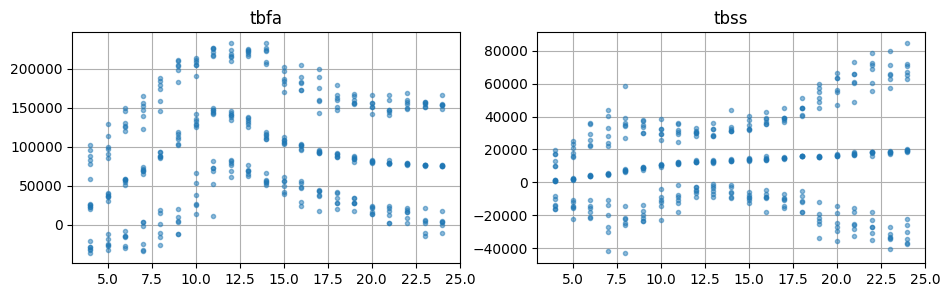

In [6]:
plot_kwargs = dict(color='C0', marker='.', linestyle='none', alpha=0.5)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11, 3))

# one plot with tbfa
key, ax = 'tbfa', ax0
plot_val(df, key, 'mean', ax=ax, **plot_kwargs)
plot_val(df, key, 'min', ax=ax, **plot_kwargs)
plot_val(df, key, 'max', ax=ax, **plot_kwargs)

# one plot with tbss
key, ax = 'tbss', ax1
plot_val(df, key, 'mean', ax=ax, **plot_kwargs)
plot_val(df, key, 'min', ax=ax, **plot_kwargs)
plot_val(df, key, 'max', ax=ax, **plot_kwargs);

There is clearly something that happens from around 6 to 9 m/s in both channels. Let's let's verify we see this in the std devs and in the DELs.

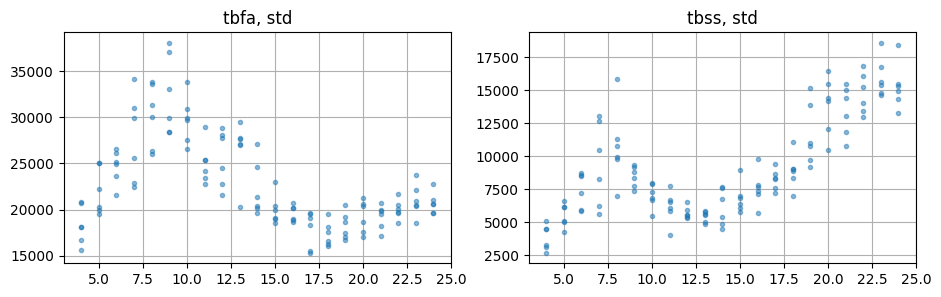

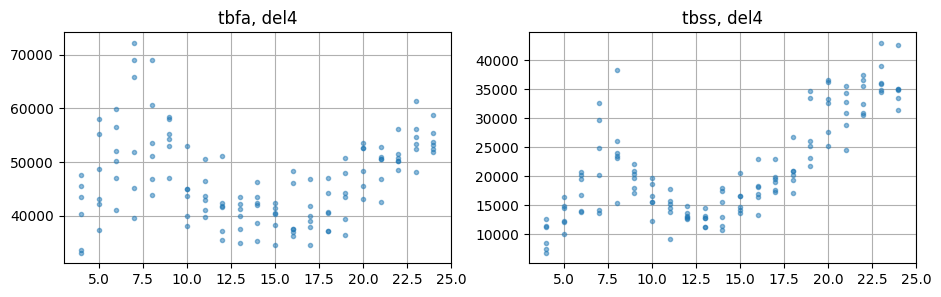

In [7]:
stat = 'std'
# one plot with tbfa
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11, 3))
key = 'tbfa'
plot_val(df, key, stat, ax=ax0, title=f'{key}, {stat}', **plot_kwargs)
key = 'tbss'
plot_val(df, key, stat, ax=ax1, title=f'{key}, {stat}', **plot_kwargs);

stat = 'del4'
# one plot with tbfa
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11, 3))
key = 'tbfa'
plot_val(df, key, stat, ax=ax0, title=f'{key}, {stat}', **plot_kwargs)
key = 'tbss'
plot_val(df, key, stat, ax=ax1, title=f'{key}, {stat}', **plot_kwargs);

Interestingly, the standard deviations and the DELs peak at slightly different times. The DELs peak around 7 or 8 m/s, and the standard deviations of the TbFA peak around 9 m/s.

As a reminder, let's look at the rotor speeds.

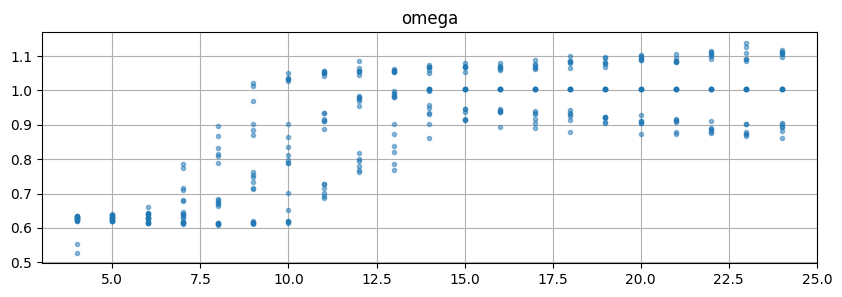

In [8]:
key = 'omega'
ax, _, _ = plot_val(df, key, 'mean', **plot_kwargs)
plot_val(df, key, 'min', ax=ax, **plot_kwargs)
plot_val(df, key, 'max', ax=ax, **plot_kwargs);

So, at 7 m/s we are starting to enter the variable-speed region.

The next question is therefore: what is causing this increase, then decrease in energy? To figure that out, we need to look at the time serie3s and PSDs. The difference is more noticeable for the TBFA, so let's look at the max-DEL time series at 7, 8 and 9 m/s.

## Time series

In [9]:
def load_timeseries(res_dir, subfolder, fname):
    path = res_dir + subfolder + '/' + fname
    return ReadHAWC2(path)

dtu_10mw_turb_tca_06.0_52870.hdf5
dtu_10mw_turb_tca_07.0_32293.hdf5
dtu_10mw_turb_tca_08.0_26343.hdf5
dtu_10mw_turb_tca_09.0_25824.hdf5


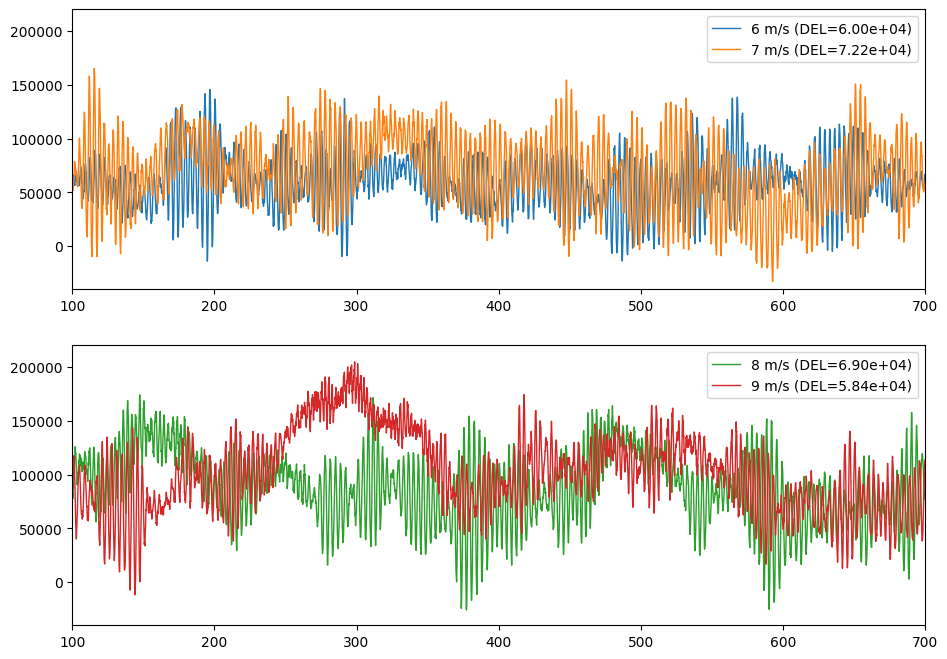

In [29]:
key = 'tbfa'

fig, axs = plt.subplots(2, 1, figsize=(11, 8))

for iu, u in enumerate((6, 7, 8, 9)):
    ax = axs[iu//2]
    wsp_df = df[(df.wsp == u) & (df.ichan == chans[key])]
    idx = wsp_df['del4'].argmax()
    fname = wsp_df.iloc[idx, :]['filename']
    del4 = wsp_df.iloc[idx, :]['del4']
    print(fname)
    
    h2res = load_timeseries(res_dir, subfolder, fname)
    xdata = h2res.data[:, 0]
    ydata = h2res.data[:, chans[key] - 1]
    
    #ax = axs[iu]
    ax.plot(xdata, ydata, label=f'{u} m/s (DEL={del4:.2e})', lw=1, c=f'C{iu}')
    ax.set(xlim=[100, 700], ylim=[-40000, 220000])
    ax.legend()

Here's what we can (sort of) observe from the time series:
 * As the wind speed increases, we can see that there becomes more larger excursions away from the mean value. This is especially noticeable in 8 and 9 m/s. Physically, we could imagine that this is due to the large variations in the wind speed causing larger variations in the thrust.
 * All simulations have some high-frequency oscillations, but the amplitudes of these oscillations are larger for 6 and 7 m/s.

We can hypothesize that the higher-frequency oscillations are the 1st tower modes (fore-aft and side-side), which are close to 3P when the rotor speed is near the minimum prescribed value.

To verify this hypothesis, let's look at the power-spectral densities (PSD).

## PSD

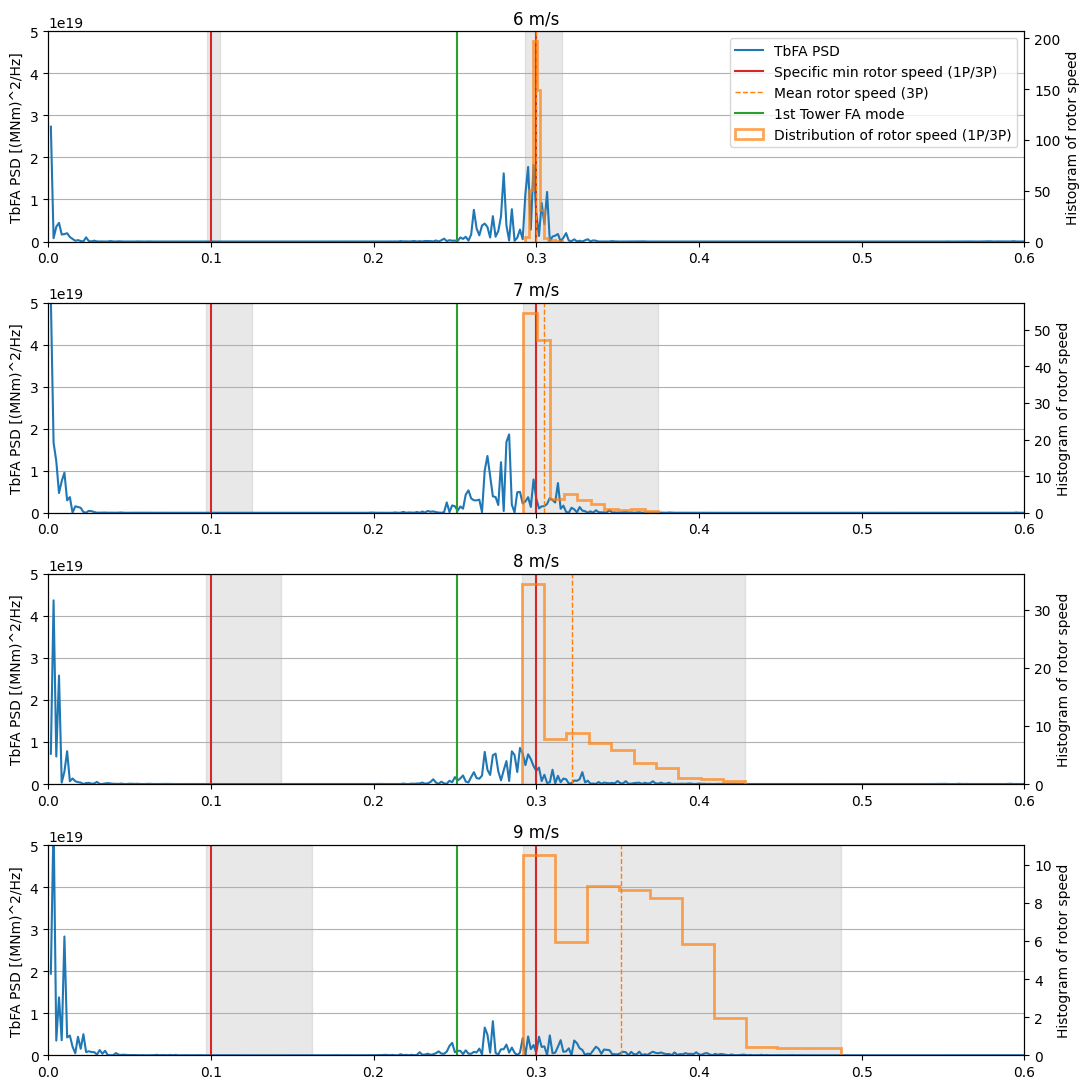

In [44]:
fig, axs = plt.subplots(4, 1, figsize=(11, 11))

fplot = np.fft.rfftfreq(ydata.size, xdata[1] - xdata[0])
deltaf = 1/600

min_rs = 6 / 60  # in Hz

for iu, u in enumerate([6, 7, 8, 9]):
    ax = axs[iu]
    
    fnames = df.loc[(df.wsp == u) & (df.ichan == chans[key]), 'filename'].values
    # load time series
    all_data = np.empty((ydata.size, 6))
    rs_data = np.empty((3, 6))  # min, mean, max rotor speed (rad/s)
    om_data = np.empty((ydata.size, 6))  # rotor speed in Hz
    for j, fname in enumerate(fnames):
        h2res = load_timeseries(res_dir, subfolder, fname)
        all_data[:, j] = h2res.data[:, chans[key] - 1]
        rs_data[0, j] = h2res.data[:, chans['omega'] - 1].min()
        rs_data[1, j] = h2res.data[:, chans['omega'] - 1].mean()
        rs_data[2, j] = h2res.data[:, chans['omega'] - 1].max()
        om_data[:, j] = h2res.data[:, chans['omega'] - 1] / (2*np.pi)
    
    # take fft, then average across rows
    FFT = np.mean(np.fft.rfft(all_data, axis=0), axis=1)
    # get PSD (sort of)
    PSD = np.abs(FFT) ** 2 * 2 / deltaf
    
    ax.plot(fplot[1:], PSD[1:], label='TbFA PSD')
    #ylim = ax.get_ylim()
    ylim = [0, 5e19]
    
    # add rotor speeds (in Hz)
    min_om = rs_data[0, :].min() / (2 * np.pi)
    mean_om = rs_data[1, :].mean() / (2 * np.pi)
    max_om = rs_data[2, :].max() / (2 * np.pi)
    
    # patch, min/max
    ax.fill_between([min_om, max_om], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='0.7', zorder=-5, alpha=0.3)
    ax.fill_between([3*min_om, 3*max_om], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='0.7', zorder=-5, alpha=0.3)
    # solid line -- specific min roto speed
    ax.plot([min_rs, min_rs], ylim, 'C3', label='Specific min rotor speed (1P/3P)')
    ax.plot([3*min_rs, 3*min_rs], ylim, 'C3', )
    # dotted line -- mean rotor speed (3P only)
    ax.plot([3*mean_om, 3*mean_om], ylim, '--', c='C1', lw=1, label='Mean rotor speed (3P)')
    # dashed line -- nat freq
    ax.plot([0.251, 0.251], ylim, c='C2', label='1st Tower FA mode')
    # histogram of rotor speed
    ax2 = ax.twinx()
    ax2.hist(3*om_data.flatten(), histtype='step', edgecolor='C1', linewidth=2, alpha=0.7, density=True,
             label='Distribution of rotor speed (1P/3P)')
    
    ax.set(xlim=[0, 0.6], ylim=ylim, title=f'{u} m/s', ylabel='TbFA PSD [(MNm)^2/Hz]')
    ax2.set(ylabel='Histogram of rotor speed')
    ax.grid(axis='y')

lines, labels = axs[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[0].legend(lines + lines2, labels + labels2, loc=0);
fig.tight_layout()

Observations:
 * There is energy content between 0.25 and 0.30 Hz, which is near the natural frequency and 3P frequencies.
 * There is energy content between 0 and 0.02 Hz, which is forcing due to the wind.
 * The 6 and 7 m/s simulations have similar energy content in the natural frequency. The 7 m/s simulation has more DELs due to the addition of the low-frequency content, which increases the post-rainflow load amplitudes and, therefore, the DELs.
 * The rotor speed at 7 m/s is primarily at or below the minimum rotor speed, which is increasing the resonance. The rotor speed drops below minimum, unlike 6 m/s, due to entering the variable-speed region, so when the rotor speed drops down, the inertia causes it to dip under.
 * The rotor speed at 8 m/s is away from the minimum enough that the energy in the mode shape is significantly reduced. This is even more obvious for 9 m/s. Compare the PSDs to the time series to see the impact.

Finally, let's look at the rainflow counts.

## Rainflow

In [92]:
fig, axs = plt.subplots(2, 2, figsize=(11, 7))

m = 4
mint, maxt = 7_000, 217_000  # remove the really small-amplitude stuff
#mint, maxt = 4_000, 217_000
bins = np.linspace(mint, maxt, 40)
bins_mid = 0.5*(bins[1:] + bins[:-1])  # mid-points of bins
for iu, u in enumerate((6, 7, 8, 9)):
    (ax0, ax1) = axs[:, iu//2]
    # isolate max-DEL
    wsp_df = df[(df.wsp == u) & (df.ichan == chans[key])]
    idx = wsp_df['del4'].argmax()
    fname = wsp_df.iloc[idx, :]['filename']
    del4 = wsp_df.iloc[idx, :]['del4']
    
    # load the time series
    h2res = load_timeseries(res_dir, subfolder, fname)
    ydata = h2res.data[:, chans[key] - 1]
    
    # rainflow count
    ampls, means = rainflow_windap(ydata)
    del4_v2 = ((1/600) * np.sum(ampls ** m))**(1/m)  # this does NOT match post-proc due to wetb binning
    D = np.sum(ampls ** m)  # use for normalizing damage below
    
    # calc histogram of cycles and plot it
    bin_n = ax0.hist(ampls, histtype='stepfilled', alpha=0.05, color=f'C{iu}', bins=bins)[0]
    ax0.hist(ampls, histtype='step', color=f'C{iu}', lw=2, alpha=0.7, label=f'{u} m/s', bins=bins)
    
    # calculate D*K of the cycles in that bin
    # 1. isolate the cycles in the bin
    # 2. calculate Dbin*K as np.sum(ampls ** m))**(1/m)
    D_bins = np.empty_like(bin_n)
    for ib, bin_start in enumerate(bins[:-1]):
        bin_stop = bins[ib + 1]
        cycles = ampls[(ampls >= bin_start) & (ampls <= bin_stop)]
        D_bins[ib] = np.sum(cycles ** m)
    
    # make a histogram of the damage in each bin
    ax1.stairs(D_bins, edges=bins, fill=True, color=f'C{iu}', alpha=0.05)
    ax1.stairs(D_bins, edges=bins, color=f'C{iu}', alpha=0.7, lw=2, label=f'DEL = {del4_v2:.2e}')
    
    ax0.set(ylim=(0, 78), ylabel='Frequency of load amplitude')
    ax1.set(ylim=(0, 5.2e21), ylabel='D_bin * K', xlabel='TbFA load amplitude (post rainflow)')

    ax0.legend()
    ax1.legend(loc=2)
fig.tight_layout();